# Detección de Viviendas Precarias en Buenos Aires usando IA

## Descripción general

Este proyecto tiene como objetivo desarrollar un modelo de segmentación semántica utilizando técnicas de inteligencia artificial para detectar áreas con viviendas precarias en Buenos Aires. Usamos imágenes satelitales de ciertos partidos seleccionados del Área Metropolitana de Buenos Aires (AMBA), y a partir de estas imágenes, aplicamos algoritmos de aprendizaje profundo para identificar zonas con características asociadas a viviendas precarias.

El enfoque principal se basa en el uso de **redes neuronales convolucionales** para la segmentación de imágenes, junto con un conjunto de datos geoespaciales procesados utilizando bibliotecas especializadas como **Rasterio** y **Raster Vision**. Estos datos incluyen imágenes satelitales con etiquetas que definen las áreas de interés.

El notebook se organiza en varios pasos clave que cubren desde la configuración del entorno y la descarga de los datos, hasta el entrenamiento del modelo y la evaluación de los resultados.

## Estructura del proyecto

1. **Importación de librerías y configuración del entorno**: Se configuran las dependencias necesarias para trabajar con datos geoespaciales y entrenar el modelo.
2. **Descargar la Data**: Importamos imagenes de Sentinel (tutorial), labels y areas de interes (AOI)
3. **Preprocesamiento de datos**: Preparamos los datos satelitales, que incluyen imágenes y anotaciones, asegurándonos de que estén listos para el modelo de segmentación.
4. **Entrenamiento del modelo**: Utilizamos **Raster Vision** para entrenar un modelo de segmentación semántica que detecta viviendas precarias.
5. **Evaluación de resultados**: Una vez entrenado el modelo, evaluamos su precisión en un conjunto de validación, generando mapas segmentados que muestran las áreas detectadas como precarias.



## Paso 1 : Importación de librerías y configuración del entorno

In [1]:
!pip install -r requirements.txt

ERROR: Could not find a version that satisfies the requirement rastervision_pipeline==0.31.2 (from versions: 0.12, 0.12.1, 0.13, 0.13.1, 0.20, 0.20.1, 0.20.2, 0.21, 0.21.1, 0.21.2, 0.21.3, 0.30.0, 0.30.1, 0.31.0, 0.31.1)
ERROR: No matching distribution found for rastervision_pipeline==0.31.2


Para este proyecto, utilizamos las siguientes bibliotecas clave:

- **rasterio**: Para manejar los archivos de imágenes satelitales.
- **torch**: Para trabajar con redes neuronales y aprendizaje profundo.
- **rastervision**: Biblioteca especializada para tareas de segmentación geoespacial.
- **albumentations**: Para realizar aumentos de datos en imágenes.

In [2]:
import gdown
import glob
import utils
import random
import numpy as np
import torch
import os
import subprocess
import rastervision
import rasterio
from subprocess import check_output
from aux_functions import download_blob_from_azure

from rastervision.core.data import RasterioSource, MinMaxTransformer

from rastervision.core.data import (
    ClassConfig, GeoJSONVectorSource, RasterioCRSTransformer,
    RasterizedSource, ClassInferenceTransformer)

from rastervision.core.data import SemanticSegmentationLabelSource

from rastervision.core.data.utils.geojson import get_polygons_from_uris
from shapely.geometry import Polygon

from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset, SemanticSegmentationSlidingWindowGeoDataset, SemanticSegmentationVisualizer)

import albumentations as A

import torch
from torch.utils.data import ConcatDataset

from rastervision.pytorch_learner import SemanticSegmentationGeoDataConfig
from rastervision.pytorch_learner import SolverConfig
from rastervision.pytorch_learner import SemanticSegmentationLearnerConfig
from rastervision.pytorch_learner import SemanticSegmentationLearner


c:\Users\oltie\anaconda3\envs\ssmodel_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\oltie\anaconda3\envs\ssmodel_env\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.19 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Es crucial tener cuda si estamos operando localmente. Es necesario para usar la GPU.

In [3]:
import torch
if torch.cuda.is_available():
    print("PyTorch version:", torch.__version__)
    print("Is CUDA available:", torch.cuda.is_available())
    print("CUDA version:", torch.version.cuda)
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device found")
    # Optionally, check where a tensor is located
    x = torch.randn(3, 3)
    print(f"device viejo: {x.device}")  # should print 'cpu' if on CPU

    # To move a tensor or model to the GPU
    x = x.cuda()
    print(f"device nuevo: {x.device}")  # should print 'cuda:0' if on GPU
    # Check if GPU is available and set the device accordingly
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    print("no tiene CUDA Disponible, no puedes seguir con el mdoelo")

PyTorch version: 2.5.0+cu124
Is CUDA available: True
CUDA version: 12.4
Number of GPUs: 1
Current device: 0
Device name: NVIDIA GeForce RTX 3060 Laptop GPU
device viejo: cpu
device nuevo: cuda:0


Además, configuramos las variables de entorno necesarias para trabajar con las bibliotecas geoespaciales, ajustando la variable GDAL_DATA y otras configuraciones relevantes.

In [4]:

# os.environ['GDAL_DATA'] = check_output('pip show rasterio | grep Location | awk \'{print $NF"/rasterio/gdal_data/"}\'', shell=True).decode().strip()
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'


# Get the location of rasterio
rasterio_location = check_output('pip show rasterio', shell=True).decode()

# Find the line that specifies the location
gdal_data_path = None
for line in rasterio_location.splitlines():
    if line.startswith("Location:"):
        gdal_data_path = os.path.join(line.split(":", 1)[1].strip(), 'rasterio', 'gdal_data')
        break

# Set the GDAL_DATA environment variable if we found the path
if gdal_data_path:
    os.environ['GDAL_DATA'] = gdal_data_path
    print(f"GDAL_DATA has been set to: {gdal_data_path}")
else:
    print("Could not find the GDAL data path.")


GDAL_DATA has been set to: C:\Users\oltie\anaconda3\envs\ssmodel_env\Lib\site-packages\rasterio\gdal_data


Para asegurar la reproducibilidad de los resultados y garantizar que el modelo se entrene de manera consistente en cada ejecución, configuramos una semilla global que controla la aleatoriedad en Python, NumPy y PyTorch. Esto asegura que cualquier operación que dependa del azar (como inicializaciones aleatorias) se realice de la misma manera en cada ejecución.

Además, ajustamos los parámetros de cuDNN (una biblioteca de aceleración de redes neuronales para GPUs NVIDIA) para hacer que las operaciones sean determinísticas y reproducibles.


In [5]:


# Set global seed for reproducibility
def set_global_seed(seed):
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # NumPy's random module
    torch.manual_seed(seed)  # PyTorch seed for CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # PyTorch seed for current GPU
        torch.cuda.manual_seed_all(seed)  # PyTorch seed for all GPUs (if using multi-GPU)

# Prepare cuDNN for deterministic behavior
def prepare_cudnn(deterministic=True):
    torch.backends.cudnn.deterministic = deterministic  # cuDNN deterministic setting
    torch.backends.cudnn.benchmark = not deterministic  # Disable cuDNN benchmarking if deterministic

# Set the seed and configure cuDNN
SEED = 42
set_global_seed(SEED)
prepare_cudnn(deterministic=True)

## Paso 2: Descargar la Data

En esta sección, descargamos los datos necesarios para entrenar el modelo. Las imágenes satelitales y los datos de anotaciones se almacenan en **Azure Blob Storage**, y se descargan de manera programática para facilitar su manejo. Estos datos incluyen imágenes en formato **GeoTIFF**, que contienen la información geoespacial necesaria para el modelo de segmentación.

Dividimos los datos en dos conjuntos: **entrenamiento** y **validación**, para evaluar el modelo de manera efectiva.

Una **aclaración importante**: para que sean compatibles con las funciones de `rastervision`, todos los archivos con polígonos georreferenciados -anotaciones y área de interés- deben tener proyección geográfica **WGS 84**, también conocida como **EPSG:4326**. Si los datos no están en esta proyección, será necesario reproyectarlos antes de usarlos en el modelo.


### Opción 1: EXPLICAR COMO EXTRER LA DATA DE SENTINEL

### Opción 2: Extraer la data de Azure

In [6]:
# Imágenes

# download_blob_from_azure('2023.tif', './data/train/img/')
train_img_uri = './data/train/img/2023.tif'

# download_blob_from_azure('2023.tif', './data/val/img/')
val_img_uri = './data/val/img/2023.tif'

In [7]:
# Labels

# download_blob_from_azure('2023_viviendas.geojson','./data/train/labels/')
train_labels_uri = './data/train/labels/2023_viviendas.geojson'

# download_blob_from_azure('2023_viviendas.geojson', './data/val/labels/')
val_labels_uri = './data/val/labels/2023_viviendas.geojson'

### Áreas de Interés (AoI)

Las áreas de interés (AoI) se dividen en dos conjuntos: entrenamiento (train) y validación (val). El conjunto de entrenamiento incluye cinco barrios, mientras que el de validación incluye dos barrios. Esta división se hizo para reducir el tiempo de cómputo. Modificando el archivo `.geojson` correspondiente, se puede ajustar qué áreas se asignan a cada conjunto.

- **Áreas de Entrenamiento (train):**
  - Morón
  - Tres de Febrero
  - La Matanza
  - Merlo
  - San Miguel

- **Áreas de Validación (val):**
  - Moreno
  - José C. Paz

In [8]:
# Áreas de interés

download_blob_from_azure('train_aoi.geojson', './data/train/')
train_AoI_uri = './data/train/train_aoi.geojson'

download_blob_from_azure('val_aoi.geojson', './data/val/')
val_AoI_uri = './data/val/val_aoi.geojson'

train_aoi.geojson: 100%|##########| 136k/136k [00:00<00:00, 149kB/s]


Downloaded 'train_aoi.geojson' to './data/train/train_aoi.geojson'


val_aoi.geojson: 100%|##########| 83.8k/83.8k [00:00<00:00, 122kB/s]

Downloaded 'val_aoi.geojson' to './data/val/val_aoi.geojson'


## Paso 3: Preprocesamiento de los datos

Antes de entrenar el modelo, es necesario preparar los datos. Esto incluye el preprocesamiento de las imágenes para que sean compatibles con el modelo de segmentación.

Uno de los retos principales en este proyecto es cómo analizar imágenes inmensas, que pueden tener varios gigabytes de tamaño, especialmente considerando que la memoria disponible en la GPU es limitada. 

### Solución: División en Recortes (Ventanas)

La solución que adoptamos es dividir la imagen aérea en una colección de recortes cuadrados (o "ventanas") de mucho menor tamaño, que puedan ser procesados uno a uno. De esta forma, el algoritmo puede analizar pequeñas partes de la imagen y aprender a reconocer patrones que coinciden con la presencia de basura o zonas precarias, basándose en las anotaciones correspondientes.

Este proceso de división en ventanas es facilitado por las funciones de la librería [rastervision](https://rastervision.io/), que nos permite manejar estas grandes imágenes de manera eficiente.

El **tamaño de las ventanas** es un parámetro crucial, ya que impacta directamente en la performance del entrenamiento del modelo. Sin embargo, no existe una receta exacta para determinar el tamaño óptimo de las ventanas. En general, cuanto mayor sea la resolución de las imágenes, más beneficios obtendremos al usar ventanas grandes.

### Recomendaciones de Tamaño de Ventanas
- **Imágenes de resolución moderada**: Para imágenes satelitales públicas, como las del [proyecto Sentinel](https://apps.sentinel-hub.com/eo-browser/) con una resolución de 10 metros por píxel, se recomienda utilizar ventanas de **128 x 128 píxeles**.
- **Imágenes de satélites comerciales o fotos aéreas de alta altura**: Para estas imágenes, que suelen tener una resolución más alta, se puede usar ventanas de **256 x 256 píxeles**.
- **Imágenes de altísima resolución**: Para imágenes con una resolución extremadamente alta, como las que tienen una resolución de 3 cm por píxel, podemos probar con ventanas de **480 x 480 píxeles**, como se hará a continuación en este notebook.

### Augmentations (Aumentaciones)

Como paso adicional de preprocesamiento, es común realizar una serie de **distorsiones** o **aumentaciones** sobre los recortes de imagen antes de pasarlos al algoritmo durante la fase de entrenamiento. Estos ajustes incluyen cambios aleatorios en el brillo, saturación, eliminación de algunos píxeles, entre otros.

A estos ajustes se les denomina **augmentations**, y aunque a primera vista pueden parecer destructivos, han demostrado mejorar significativamente la performance del algoritmo. Las augmentations hacen al modelo más **robusto**, es decir, lo preparan para detectar objetos en imágenes nuevas que no se usaron para su entrenamiento, pero que inevitablemente presentarán pequeñas diferencias en aspectos como la saturación, brillo o píxeles faltantes.

A continuación, veremos cómo aplicar este proceso en las imágenes a analizar.

In [9]:
# Aquí definimos las clases (tipos de objeto) presentes en nuestras anotaciones
# en este caso tenemos sólo una, que indicamos como "viviendas precarias" .
# hay un clase adicional, implícita, que es "background" -el fondo, todo lo que
# no corresponde a objetos de intéres

class_config = ClassConfig(
    names=['background', 'viviendas precarias'],
    colors=['lightgray', 'darkred'],
    null_class='background')


# el tamaño en píxeles de los recortes cuadrados
window_size = 128

# Aquí definimos algunas transformaciones a realizar a los recorte del dataset
# de entrenamiento: cambiar al azar la saturación, el brillo, rotarlos, ocultar
# algunos pixeles. Todo esto sirve para entrenar un algoritmo de detección
# más robusto a diferencias que puedan tener las futuras imágenes a las que
# se aplique
data_augmentation_transform = A.Compose([
    A.Flip(),
    A.ShiftScaleRotate(),
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=10),
        A.RandomBrightnessContrast(),
        A.RandomGamma(),
        A.RGBShift(),
        # A.ToGray(),
        # A.ToSepia(),
    ]),
    A.CoarseDropout(max_height=int(window_size/6), max_width=int(window_size/6), max_holes=4)
])


### Creación de los datasets de entrenamiento (train) y de validacion (val)

#### Ejemplo de muestreo al azar:

A continuación, visualizaremos cómo luce un muestreo al azar con ventanas solapadas extraídas de una imagen satelital, lo cual ayuda al algoritmo a aprender patrones más diversos y, por tanto, mejora la calidad de su predicción.


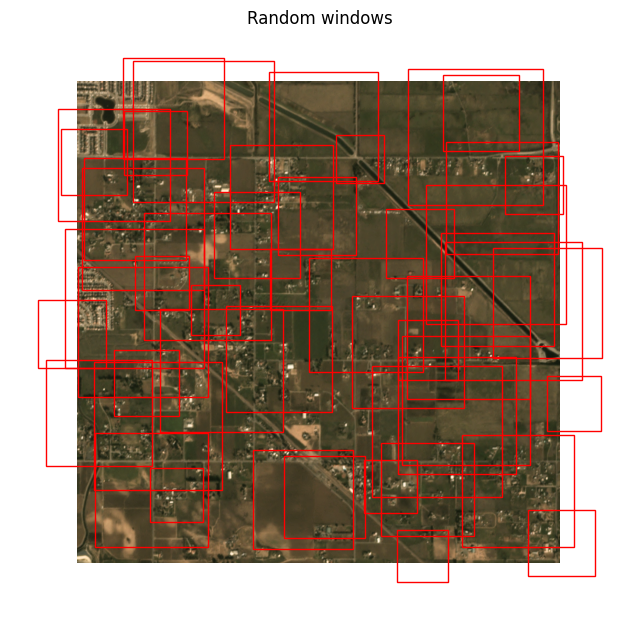

#### Dataset de Validación

El dataset de validación se utiliza para medir la performance del algoritmo en la detección de viviendas precarias. Después de cada iteración en la que el modelo ha procesado ejemplos de viviendas precarias para "aprender" los rasgos visuales asociados a su presencia, evaluamos su rendimiento haciendo que recorra cada punto del área de trabajo. Durante este proceso, el algoritmo debe identificar correctamente cada instancia conocida de viviendas precarias dentro del área de validación.

Este proceso nos permite evaluar de manera objetiva qué tan bien ha aprendido el modelo a detectar viviendas precarias en áreas nuevas, y ajustar los hiperparámetros si es necesario para mejorar la precisión de la detección.

In [10]:
def create_val_ds(image_uris, class_config, AoI_file_dest_uri, val_labels_uri, window_size):
    datasets = []
    
    # Asegurar que image_uris es una lista
    if not isinstance(image_uris, list):
        image_uris = [image_uris]

    for image_uri in image_uris:
        val_ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
            class_config=class_config,
            aoi_uri=AoI_file_dest_uri,
            image_uri=image_uri,
            label_vector_uri=val_labels_uri,
            label_vector_default_class_id=class_config.get_class_id('viviendas precarias'),
            image_raster_source_kw=dict(allow_streaming=True, raster_transformers=[MinMaxTransformer()]),
            size=window_size,
            stride=window_size,
            transform=A.Resize(window_size, window_size)
        )
        datasets.append(val_ds)

    # Concatenamos todo los datasets 
    combined_val_ds = sum(datasets[1:], datasets[0]) if datasets else None
    
    return combined_val_ds


In [11]:
# Crear el dataset de validación
val_ds = create_val_ds(
    image_uris=val_img_uri,
    class_config=class_config,
    AoI_file_dest_uri=val_AoI_uri,
    val_labels_uri=val_labels_uri,
    window_size=window_size
)

len(val_ds)

106

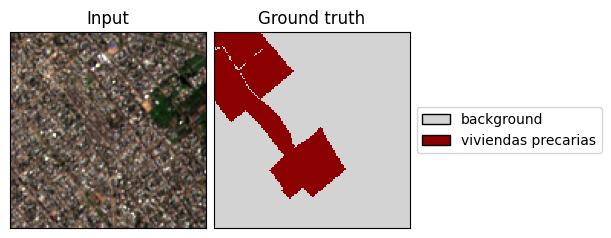

In [12]:
vis = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors)

x, y = val_ds[10]

vis.plot_batch(x.unsqueeze(0), y.unsqueeze(0), show=True)

#### Dataset de Entrenamiento

Para el dataset de entrenamiento, en lugar de utilizar un mosaico de ventanas contiguas que cubra toda la imagen sin solapamientos, optamos por realizar un **muestreo al azar** de las ventanas. En este proceso, el algoritmo va a procesar ventanas extraídas al azar de la imagen, comparando los resultados con las anotaciones, lo que le permitirá descubrir qué patrones visuales corresponden a la presencia de viviendas precarias.

Aunque pueda parecer contraintuitivo al principio, el **muestreo al azar con ventanas solapadas** ha demostrado producir mejores resultados que entrenar al algoritmo con una grilla regular de ventanas en las que ningún píxel se repite entre recortes. La razón es que las ventanas solapadas permiten al modelo ver múltiples versiones del mismo punto de la imagen, lo que contribuye a una mayor robustez y capacidad de generalización.

In [13]:
def create_train_ds(image_uris, class_config, AoI_file_dest_uri, train_labels_uri, window_size, sample_size, data_augmentation_transform):
    datasets = []
    
    # Asegurar que image_uris es una lista
    if not isinstance(image_uris, list):
        image_uris = [image_uris]

    for image_uri in image_uris:
        train_ds = SemanticSegmentationRandomWindowGeoDataset.from_uris(
            class_config=class_config,
            aoi_uri=AoI_file_dest_uri,
            image_uri=image_uri,
            label_vector_uri=train_labels_uri,
            label_vector_default_class_id=class_config.get_class_id('viviendas precarias'),
            image_raster_source_kw=dict(allow_streaming=True, raster_transformers=[MinMaxTransformer()]),
            size_lims=(window_size, window_size + 1),
            out_size=window_size,
            padding=100,  # Ajustar padding
            max_windows=sample_size,
            transform=data_augmentation_transform
        )
        datasets.append(train_ds)
    
    # Concatenamos todo los datasets
    combined_train_ds = sum(datasets[1:], datasets[0]) if datasets else None
    
    return combined_train_ds

In [14]:
# Crear el dataset de entrenamiento
train_ds = create_train_ds(
    image_uris=train_img_uri,
    class_config=class_config,
    AoI_file_dest_uri=train_AoI_uri,
    train_labels_uri=train_labels_uri,
    window_size=window_size,
    sample_size= len(val_ds)*10, #como las area de val es mas chica me aseguro de que train tenga 10 veces mas de imagenes para cubrir mejor el area con random windows.
    data_augmentation_transform=data_augmentation_transform
)

len(train_ds)


1060

Para que PyTorch pueda procesar correctamente las imágenes en términos de los valores de los píxeles, es necesario asegurarse de que estos valores estén en el formato adecuado. Específicamente, PyTorch requiere que los valores de los píxeles se pasen como tipo **long** (enteros de 64 bits), lo que garantiza que las operaciones sobre los datos de las imágenes se realicen de manera precisa y eficiente.


In [15]:
from torch.utils.data import Dataset

class LongTargetDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        x, y = self.base_dataset[idx]
        y = y.long()  # Ensure target is LongTensor
        return x, y

In [16]:
# Wrap train and validation datasets
train_ds = LongTargetDataset(train_ds)
val_ds = LongTargetDataset(val_ds)

Vamos a elegir algunos de los recortes de imagen al azar para visualizarlos y verificar cómo quedan. Al ejecutar este proceso varias veces, notarás que cada vez obtendrás resultados diferentes, lo que demuestra que la selección de ventanas es efectivamente aleatoria.

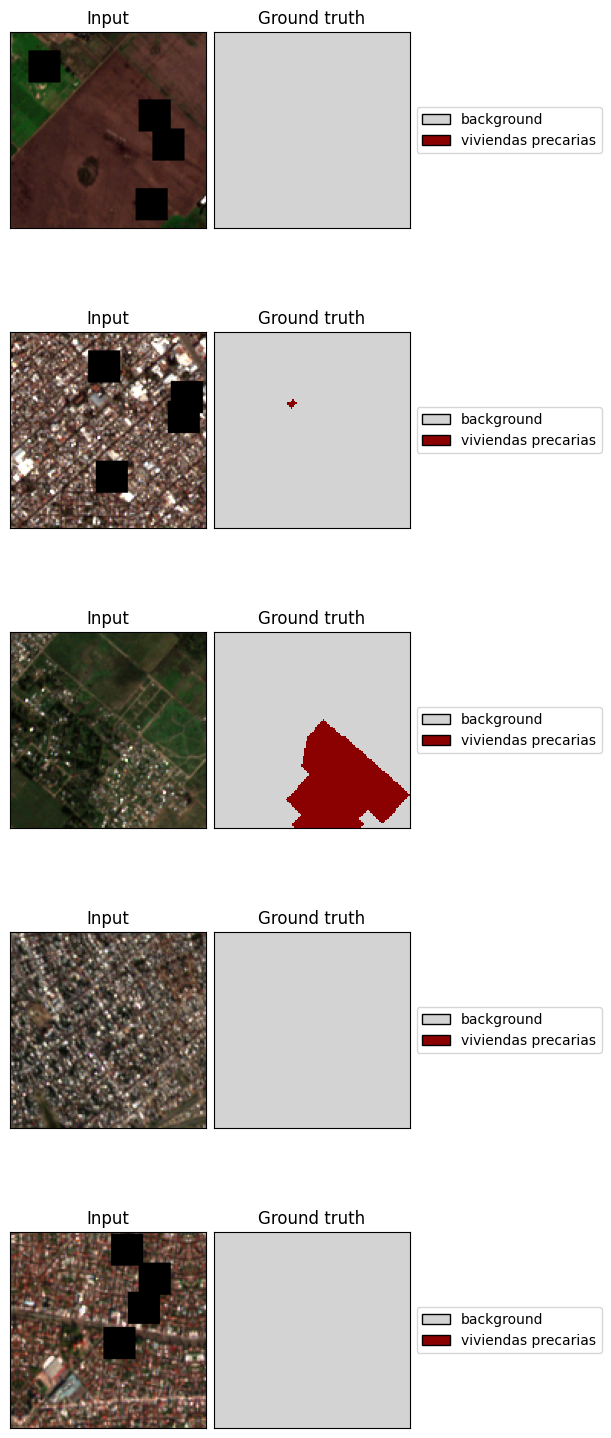

In [17]:
x, y = vis.get_batch(train_ds, 5)

vis.plot_batch(x, y, show=True)

## Paso 4: Entrenamiento del modelo


#### Utilización de un Modelo Preentrenado

Tomaremos como base un modelo de uso general llamado **ResNet18**, una red neuronal convolucional ampliamente utilizada para tareas de clasificación y detección de objetos. Este modelo ya ha sido preentrenado en grandes conjuntos de datos, lo que le permite reconocer patrones visuales generales. Sin embargo, podemos **re-entrenar** este modelo para que se especialice en la detección de **viviendas precarias**.

#### Uso de un modelo ligero: Panoptic FPN con ResNet-18

Vamos a utilizar un modelo **Panoptic Feature Pyramid Network (FPN)** con un backbone basado en **ResNet-18**. Este modelo ligero es adecuado para tareas de segmentación semántica, ya que permite extraer características relevantes de las imágenes a diferentes escalas.

Este enfoque está extraído del siguiente repositorio: [Panoptic FPN con ResNet-18](https://github.com/AdeelH/pytorch-fpn).


Definimos el modelo base con el que vamos a trabajar:

In [18]:
import torch

model = torch.hub.load(
    'AdeelH/pytorch-fpn:0.3',
    'make_fpn_resnet',
    name='resnet18',
    fpn_type='panoptic',
    num_classes=len(class_config),
    fpn_channels=128,
    in_channels=3,
    out_size=(window_size, window_size),
    pretrained=True).to(device)


Using cache found in C:\Users\oltie/.cache\torch\hub\AdeelH_pytorch-fpn_0.3


#### Configuración de las Opciones para el Entrenamiento

En esta sección, configuramos las opciones clave para el proceso de entrenamiento del modelo. Estos parámetros influyen en la cantidad de iteraciones, el tamaño del batch, dónde se guardarán los resultados, y los datasets que se utilizarán.

- Cantidad de iteraciones / epocas: Define cuántas veces el modelo recorrerá todos los datos de entrenamiento. Cuantas más iteraciones, más oportunidades tendrá el modelo para ajustar sus pesos y mejorar su capacidad de predicción.
- Tamaño del batch: Determina cuántas imágenes se procesarán simultáneamente en cada iteración, balanceando la velocidad de entrenamiento y los límites de memoria.
- Guardado del modelo: Guardamos el modelo después de cada iteración para mantener su progreso.
- Datasets de entrenamiento y validación: Definimos los datasets que el modelo usará para aprender y para medir su capacidad de generalización.

In [19]:
# Set the number of epochs and the directory to save the model
n_epochs = 100
model_folder = f"./data/models/bundle_sentinel_{n_epochs}/"

# Define the batch size for training
batch_images = 64

# Configure the dataset with the class information
data_cfg = SemanticSegmentationGeoDataConfig(
    class_config=class_config,
    num_workers=0  # Set to 0 for Google Colab, to avoid multiprocessing issues
)

# Configure the solver (optimizer and scheduler)
solver_cfg = SolverConfig(
    batch_sz=batch_images,
    lr=3e-2,
    num_epochs=n_epochs,  # Specify number of epochs in the solver config
    class_loss_weights=[1.0, 10.0]  # Lower weight for background, higher for houses (nn.CrossEntropyLoss)
)

# Build the optimizer and scheduler from solver configuration
optimizer = solver_cfg.build_optimizer(model)
scheduler = solver_cfg.build_epoch_scheduler(optimizer)

# Combine everything into the learner configuration
learner_cfg = SemanticSegmentationLearnerConfig(
    data=data_cfg,
    solver=solver_cfg
)

# Instantiate the learner with the built optimizer and scheduler
learner = SemanticSegmentationLearner(
    cfg=learner_cfg,
    output_dir=model_folder,
    model=model,
    train_ds=train_ds,
    valid_ds=val_ds,
    training=True
)

# Now manually set the optimizer and scheduler into the learner if needed
learner.optimizer = optimizer
learner.scheduler = scheduler


2024-10-24 14:30:55:rastervision.pytorch_learner.learner: INFO - Building dataloaders


#### Visualización del Progreso con TensorBoard

Para monitorear el progreso del entrenamiento y evaluar la performance del modelo, utilizamos **TensorBoard**. Esta herramienta nos permite visualizar gráficas que muestran cómo evolucionan las métricas de rendimiento a lo largo de las iteraciones, incluyendo:

- **F1-score**: Una métrica balanceada que combina la precisión y el recall.
- **Recall**: La capacidad del modelo para identificar correctamente todas las instancias positivas.
- **Precisión**: La proporción de predicciones correctas entre todas las predicciones realizadas como positivas.

In [20]:
%load_ext tensorboard

In [21]:
logdir = f"./data/models/bundle_sentinel_{n_epochs}/tb-logs"
%tensorboard --bind_all --logdir $logdir --reload_interval 10

Reusing TensorBoard on port 6006 (pid 24316), started 1 day, 1:45:28 ago. (Use '!kill 24316' to kill it.)

*Y* con todo definido, finalmente... ¡a entrenar!:

In [22]:
# Inicia el entrenamiento
learner.train(epochs=n_epochs)

2024-10-24 14:30:55:rastervision.pytorch_learner.learner: INFO - train_ds: 1060 items
2024-10-24 14:30:55:rastervision.pytorch_learner.learner: INFO - valid_ds: 106 items
2024-10-24 14:30:55:rastervision.pytorch_learner.learner: INFO - Plotting sample training batch.
2024-10-24 14:31:02:rastervision.pytorch_learner.learner: INFO - Plotting sample validation batch.
2024-10-24 14:31:09:rastervision.pytorch_learner.learner: INFO - epoch: 0
Validating: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]
2024-10-24 14:31:26:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 0,
 'train_loss': 0.8789449334144592,
 'train_time': '0:00:15.721634',
 'val_loss': 0.6340566873550415,
 'avg_precision': 0.8680751919746399,
 'avg_recall': 0.8121505379676819,
 'avg_f1': 0.8391821384429932,
 'background_precision': 0.9340078234672546,
 'background_recall': 0.8533048629760742,
 'background_f1': 0.8918343186378479,
 'viviendas precarias_precision': 0.2208360731601715,
 'viviendas precarias_recall':

Visualizamos las predicciones:

2024-10-24 15:06:33:rastervision.pytorch_learner.learner: INFO - Making and plotting sample predictions on the valid set...


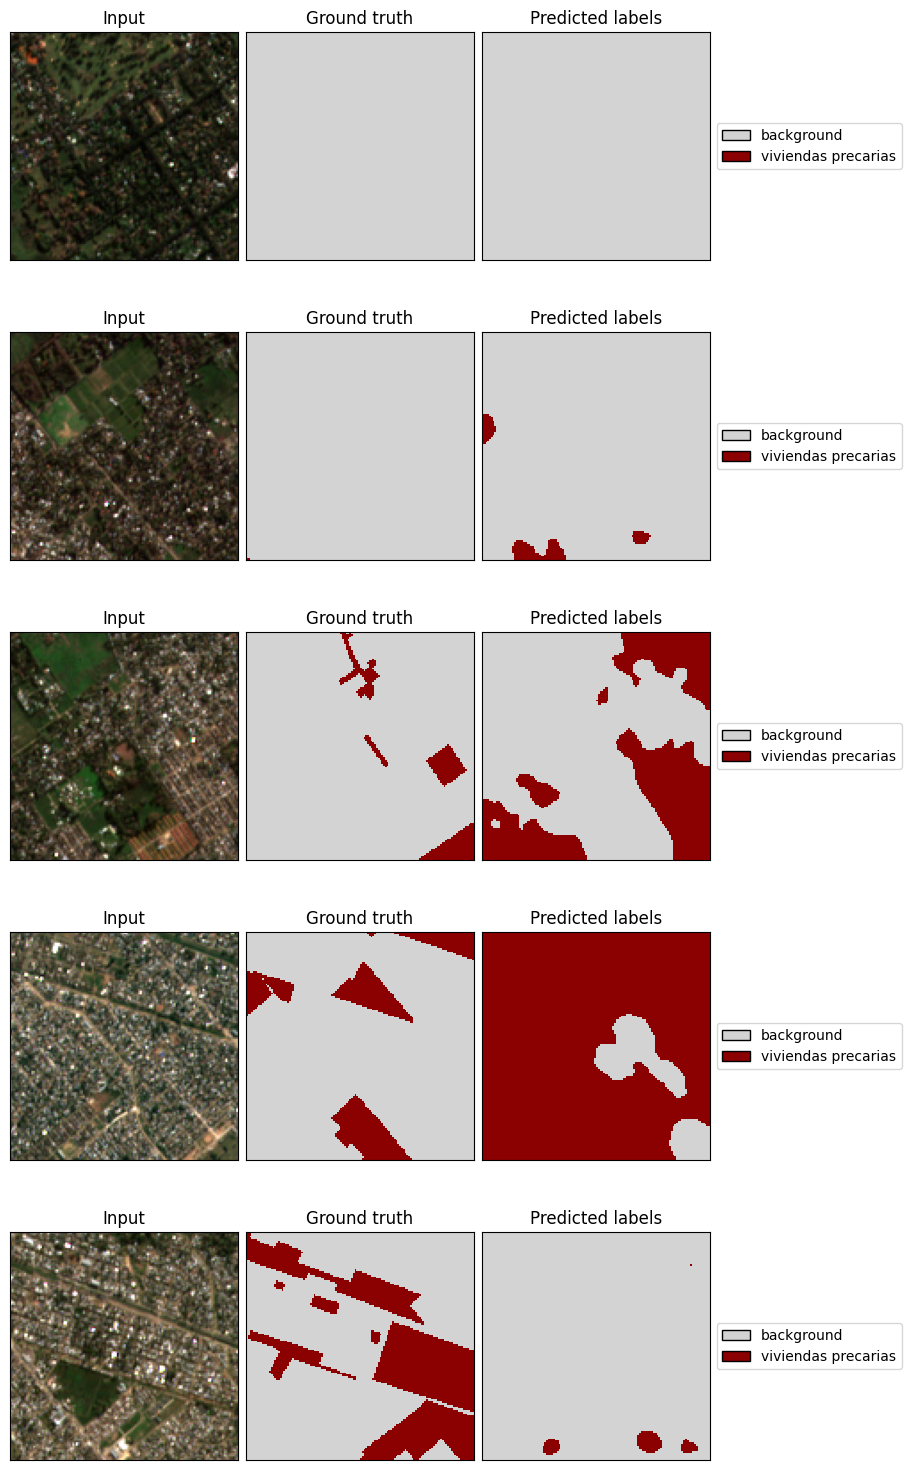

2024-10-24 15:06:37:rastervision.pytorch_learner.learner: INFO - Sample predictions written to ./data/models/bundle_sentinel_100/valid_preds.png.


In [23]:
learner.plot_predictions(split='valid', show=True,batch_limit=5)

Guardamos el modelo en un .zip. 

La función `save_model_bundle()` guarda un archivo con nombre "model-bundle.zip" en la carpeta que definimos antes, al momento de configurar el entrenamiento:

In [24]:
learner.save_model_bundle()

2024-10-24 15:06:37:rastervision.pytorch_learner.learner: WARNING - Model was not configured via ModelConfig, and therefore, will not be reconstructable form the model-bundle. You will need to initialize the model yourself and pass it to from_model_bundle().
2024-10-24 15:06:37:rastervision.pytorch_learner.learner: INFO - Creating bundle.
2024-10-24 15:06:38:rastervision.pytorch_learner.learner: INFO - Exporting to model to ONNX.
2024-10-24 15:06:39:rastervision.pytorch_learner.learner: INFO - Saving bundle to ./data/models/bundle_sentinel_100/model-bundle.zip.
Zipping: 2it [00:02,  1.01s/it, model.pth]      

LO DE ABAJO ESTA INCOPLETO Y NO SE USO TODAVIA


### Paso 4 (opcional): fine-tunning de un modelo ya usado.

agarrar el mdoelo utilizado anteriormente y entrenarlo con nuevas imagenes.

In [25]:
fine_tuning = False

In [26]:
if fine_tuning:
    #BSUCAR NUEVA DATA Y HACER LOS DATASETS
    from rastervision.pytorch_learner import SemanticSegmentationLearner

    learner = SemanticSegmentationLearner.from_model_bundle(
        model_bundle_uri=f'data/models/bundle_sentinel_{n_epochs}/model-bundle.zip',
        output_dir=f'data/models/bundle_sentinel_{n_epochs}_extra/',
        model=model,
        train_ds=train_ds_nueva,
        valid_ds=val_ds_nueva,
        training=True,
    )
    # Inicia el entrenamiento
    learner.train(epochs=n_epochs)

# _____________________________________________________________________


## Paso 5: Predecir

In [27]:
import glob
from pathlib import Path

import gc

import os

import torch

from rastervision.core.data import ClassConfig
from rastervision.core.data import SemanticSegmentationLabels, SemanticSegmentationDiscreteLabels
from rastervision.core.data import RasterioSource, MinMaxTransformer
from rastervision.core.data.label_store.semantic_segmentation_label_store_config import PolygonVectorOutputConfig

from rastervision.pytorch_learner import SemanticSegmentationLearner
from rastervision.pytorch_learner import SolverConfig
from rastervision.pytorch_learner import SemanticSegmentationLearnerConfig
from rastervision.pytorch_learner import SemanticSegmentationSlidingWindowGeoDataset
from rastervision.pytorch_learner import SemanticSegmentationGeoDataConfig

from aux_functions import download_blob_from_azure

In [28]:
# import gdown

# model_folder = "/content/drive/MyDrive/IA/basurales/modelo_pre_entrenado/"
model_folder = "./data/models/"
# !mkdir -p $model_folder
# model_url = "https://drive.google.com/file/d/1DdjZBPrMNsCp35tZSk7u-EgnIYe0wDu9/view?usp=sharing"
model_path = f"./data/models/bundle_sentinel_{n_epochs}/model-bundle.zip"

# gdown.download(model_url, model_path, fuzzy=True)

In [29]:
class_config = ClassConfig(
    names=['background', 'viviendas precarias'],
    colors=['lightgray', 'darkred'],
    null_class='background')
class_config.ensure_null_class()


window_size = 64

model = torch.hub.load(
    'AdeelH/pytorch-fpn:0.3',
    'make_fpn_resnet',
    name='resnet18',
    fpn_type='panoptic',
    num_classes=len(class_config),
    fpn_channels=128,
    in_channels=3,
    out_size=(window_size, window_size),
    pretrained=True).to(device)


learner = SemanticSegmentationLearner.from_model_bundle(model_bundle_uri=model_path, model=model, output_dir=model_folder, training=False)

Using cache found in C:\Users\oltie/.cache\torch\hub\AdeelH_pytorch-fpn_0.3
2024-10-24 15:06:44:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle ./data/models/bundle_sentinel_100/model-bundle.zip.
2024-10-24 15:06:44:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to C:\Users\oltie\AppData\Local\Temp\tmpr7bu376h\model-bundle
2024-10-24 15:06:44:rastervision.pytorch_learner.learner: INFO - Loading model weights from: C:\Users\oltie\AppData\Local\Temp\tmpr7bu376h\model-bundle\model.pth


In [30]:
# from aux_functions import combine_geojsons
# combine_geojsons('test', [
#     './data/aoi/lomas_de_zamora.geojson',
#     './data/aoi/quilmes.geojson'
# ], 'data/test')

In [31]:
download_blob_from_azure("2023.tif", "./data/test/img/")
test_img_uri = "./data/test/img/2023.tif"

download_blob_from_azure("2023_viviendas.geojson", "./data/test/labels/")
test_labels_uri = "./data/test/labels/2023_viviendas.geojson" 

download_blob_from_azure('test_aoi.geojson', './data/test/')
test_Aoi_uri = "./data/test/test_aoi.geojson"


2023.tif: 100%|##########| 362M/362M [09:26<00:00, 639kB/s]    


Downloaded '2023.tif' to './data/test/img/2023.tif'


2023_viviendas.geojson: 100%|##########| 1.58M/1.58M [00:02<00:00, 740kB/s]


Downloaded '2023_viviendas.geojson' to './data/test/labels/2023_viviendas.geojson'


test_aoi.geojson: 100%|##########| 38.5k/38.5k [00:00<00:00, 173kB/s]

Downloaded 'test_aoi.geojson' to './data/test/test_aoi.geojson'


In [32]:
window_size = 64
save_dir = f"./data/results/preds_sentinel_{n_epochs}/"

img_raster_source = RasterioSource(test_img_uri, allow_streaming=True, raster_transformers=[MinMaxTransformer()])

pred_ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=test_img_uri,
    image_raster_source_kw=dict(allow_streaming=True),
    aoi_uri=test_Aoi_uri,
    size=window_size,
    stride=window_size)

predictions = learner.predict_dataset(
    pred_ds,
    raw_out=True,
    numpy_out=True,
    predict_kw=dict(out_shape=(window_size, window_size)),
    progress_bar=True)

pred_labels = SemanticSegmentationLabels.from_predictions(
    pred_ds.windows,
    predictions,
    smooth=True,
    extent=pred_ds.scene.extent,
    num_classes=len(class_config))

# # liberamos memoria
# del pred_ds
# gc.collect()

# Guardar predicciones
pred_labels.save(
    uri=save_dir,
    crs_transformer=img_raster_source.crs_transformer,
    class_config=class_config,
    # set to False to skip writing `labels.tif`
    discrete_output=False,
    # set to False to skip writing `scores.tif`
    smooth_output=False,
    # set to True to quantize floating point score values to uint8 in scores.tif to reduce file size
    smooth_as_uint8=True,
    # vector outputs are now always written to <pred root URI>/vector_outputs/class-<i>-<class name>.json
    vector_outputs=[PolygonVectorOutputConfig(class_id=1)]
)

# # renombramos el archivo con la predicción
# !mv {save_dir + "vector_output/class-1-basural.json"} {save_dir + "vector_output/" + Path(raster_file).stem + "_prediction.json"}

# # limpieza final
# del predictions
# del pred_labels
# gc.collect()

Predicting: 100%|██████████| 354/354 [00:02<00:00, 160.25it/s]
2024-10-24 15:16:18:rastervision.core.data.label_store.semantic_segmentation_label_store: INFO - Writing vector outputs to disk.
Vectorizing predictions: 100%|██████████| 1/1 [00:04<00:00,  4.28s/it, class_id=1, denoise=8, threshold=None, type_hint=polygon_vector_output]


In [33]:
scores = pred_labels.get_score_arr(pred_labels.extent)

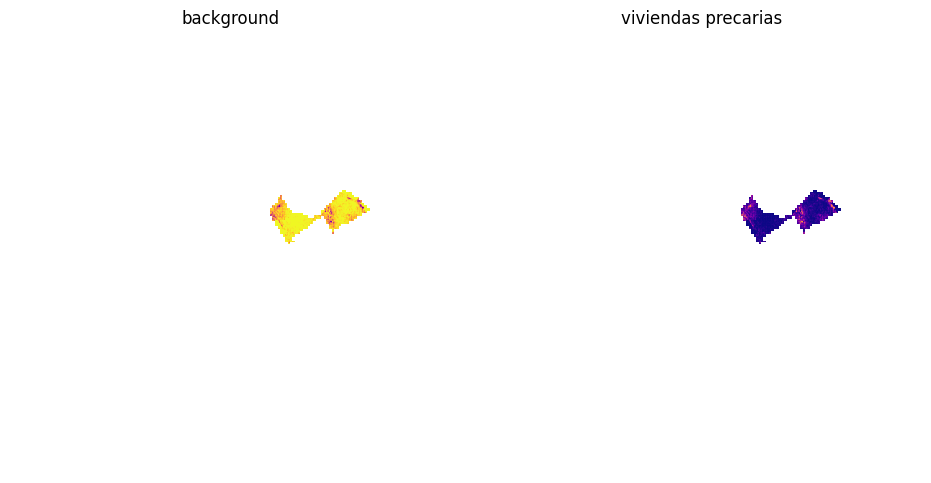

In [34]:
from matplotlib import pyplot as plt

scores_vivienda = scores[1]
scores_background = scores[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(w_pad=-2)
ax1.imshow(scores_background, cmap='plasma')
ax1.axis('off')
ax1.set_title('background')
ax2.imshow(scores_vivienda, cmap='plasma')
ax2.axis('off')
ax2.set_title('viviendas precarias')
plt.show()

In [35]:
pred_labels.save(
    uri=save_dir,
    crs_transformer=img_raster_source.crs_transformer,
    class_config=class_config,
    # discrete_output=False,
    # smooth_output=False,
    smooth_as_uint8=True,
    vector_outputs=[PolygonVectorOutputConfig(class_id=1)]
)

Saving pixel scores: 100%|██████████| 22/22 [00:05<00:00,  3.96it/s]
2024-10-24 15:16:45:rastervision.core.data.label_store.semantic_segmentation_label_store: INFO - Writing vector outputs to disk.
Vectorizing predictions: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it, class_id=1, denoise=8, threshold=None, type_hint=polygon_vector_output]


In [36]:
from rastervision.core.data.utils import make_ss_scene

scene = make_ss_scene(
    class_config=class_config,
    image_uri=test_img_uri,
    label_vector_uri=test_labels_uri,
    label_vector_default_class_id=class_config.get_class_id('viviendas precarias'),
    label_raster_source_kw=dict(
        background_class_id=class_config.get_class_id('background')),
    image_raster_source_kw=dict(allow_streaming=True))

gt_labels = scene.label_source.get_labels()

In [37]:
from rastervision.core.evaluation import SemanticSegmentationEvaluator

evaluator = SemanticSegmentationEvaluator(class_config)

evaluation = evaluator.evaluate_predictions(
    ground_truth=gt_labels, predictions=pred_labels)

Computing metrics: 100%|██████████| 1/1 [00:28<00:00, 28.06s/it]


In [38]:
evaluation.class_to_eval_item[0]

{'class_id': 0,
 'class_name': 'background',
 'conf_mat': [[16173.0, 1972234.0], [6062.0, 118565931.0]],
 'conf_mat_dict': {'FN': 6062.0,
                   'FP': 1972234.0,
                   'TN': 16173.0,
                   'TP': 118565931.0},
 'conf_mat_frac': [[0.00013414852638179701, 0.016358887329504548],
                   [5.028185042518107e-05, 0.9834566822936884]],
 'conf_mat_frac_dict': {'FN': 5.028185042518107e-05,
                        'FP': 0.016358887329504548,
                        'TN': 0.00013414852638179701,
                        'TP': 0.9834566822936884},
 'count_error': 1966172.0,
 'gt_count': 118571993.0,
 'metrics': {'f1': 0.9917264242701057,
             'precision': 0.9836380950381981,
             'recall': 0.9999488749421628,
             'sensitivity': 0.9999488749421628,
             'specificity': 0.008133646682997998},
 'pred_count': 120538165.0,
 'relative_frequency': 0.9835069641441136}

In [39]:
evaluation.class_to_eval_item[1]

{'class_id': 1,
 'class_name': 'viviendas precarias',
 'conf_mat': [[118565931.0, 6062.0], [1972234.0, 16173.0]],
 'conf_mat_dict': {'FN': 1972234.0,
                   'FP': 6062.0,
                   'TN': 118565931.0,
                   'TP': 16173.0},
 'conf_mat_frac': [[0.9834566822936884, 5.028185042518107e-05],
                   [0.016358887329504548, 0.00013414852638179701]],
 'conf_mat_frac_dict': {'FN': 0.016358887329504548,
                        'FP': 5.028185042518107e-05,
                        'TN': 0.9834566822936884,
                        'TP': 0.00013414852638179701},
 'count_error': 1966172.0,
 'gt_count': 1988407.0,
 'metrics': {'f1': 0.01608739895018606,
             'precision': 0.7273667641106364,
             'recall': 0.008133646682997998,
             'sensitivity': 0.008133646682997998,
             'specificity': 0.9999488749421628},
 'pred_count': 22235.0,
 'relative_frequency': 0.016493035855886344}

In [40]:
evaluation.save(f'data/results/eval_sentinel_{n_epochs}.json')